In [1]:
#Building of Micrograd!! It is a library used for autograd work i.e, backpropagation during Gradient Descent

In [2]:
!pip install matplotlib

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Creating an example function
def k(x,y):
    return 3*x**2+2*y**2+4

In [5]:
k(4.0,5.0)

102.0

In [6]:
def g(x):
    return 5*x**2-2*x+2

In [7]:
g(3)

41

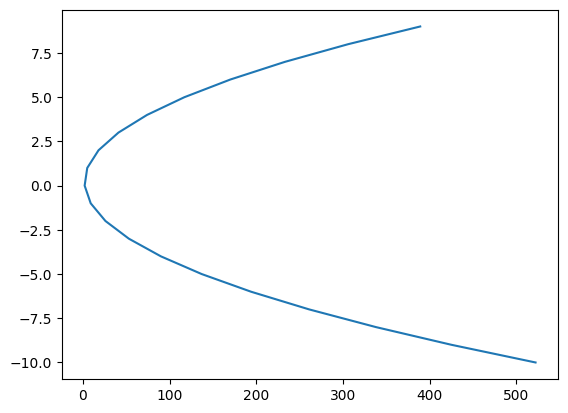

In [8]:
#Taking in set of values in a variable
xa=np.arange(-10,10,1)#Taking in all the values from -10 to 10 with 0.5 interval
ya=g(xa)
plt.plot(ya,xa)

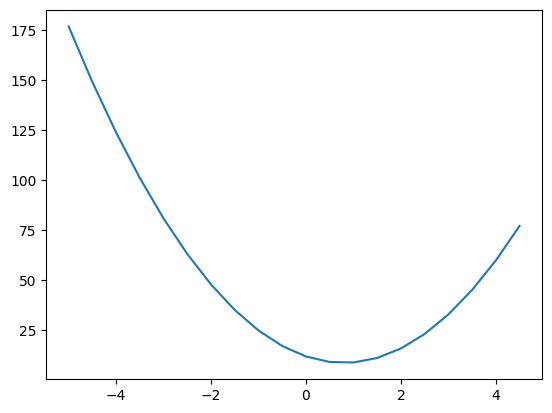

In [9]:
#Taking complex functions with multi variables to check the plot
xx=np.arange(-5,5,0.5)
yy=k(xx,np.arange(-7,3,0.5))
plt.plot(xx,yy)

In [10]:
#Evaluating the derivatives of the functions with respect with each variables

In [11]:
#Creating a Value object for operations of variables as expressions in nn are massive

In [12]:
#This class Value has predefined functions for all arithmatic operations
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) #Used to operate normal numbers as object of Value class 
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out


    
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [13]:
def f(x):
  return 3*x**2 - 4*x + 5

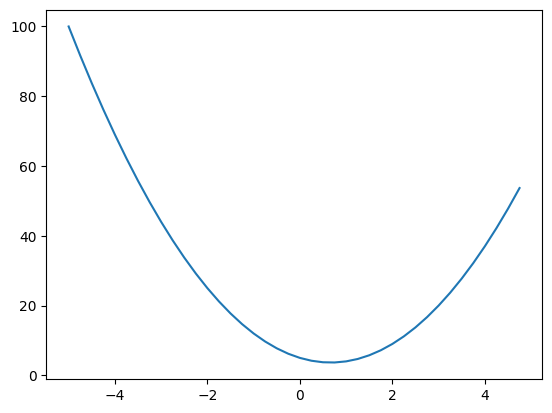

In [14]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [15]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [16]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [17]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [18]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [19]:
!pip install graphviz

In [20]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

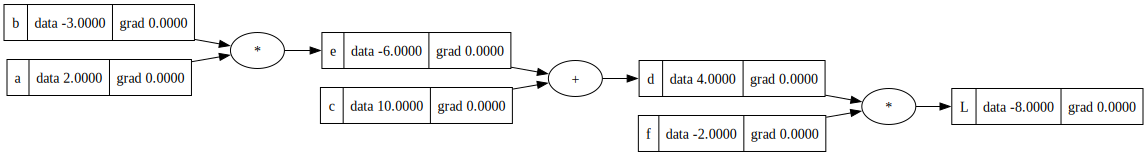

In [21]:
draw_dot(L)

In [22]:
#Calculated Manually by using limit function for derivatives
a.grad= 6.0
b.grad= -4.0
f.grad = 4.0
d.grad =-2.0
L.grad = 1.0
e.grad= -2.0
c.grad= -2.0

In [23]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [24]:
#Inline gradient check for gradient descent before backpropagation
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)

In [25]:
lol()

-3.9999999999995595


In [26]:
#BackPropagation through a neuron
#tanh is the activation function used here

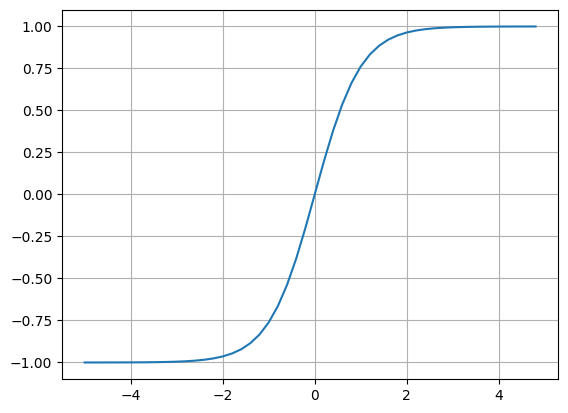

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [29]:
# tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))

In [30]:
#derivative of tanh(x) function
#d(tanh(x))/dx = 1-(tanh(x))^2

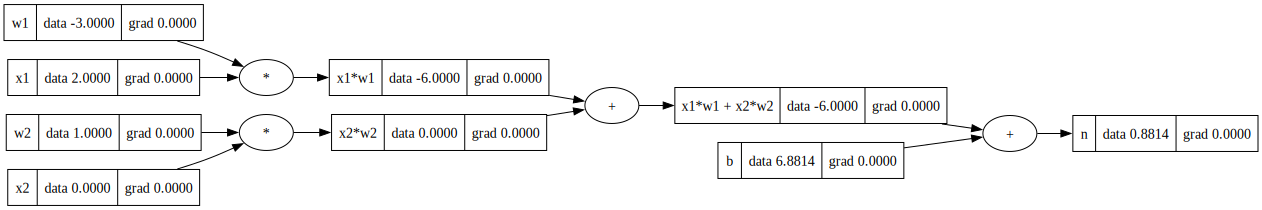

In [31]:
draw_dot(n)

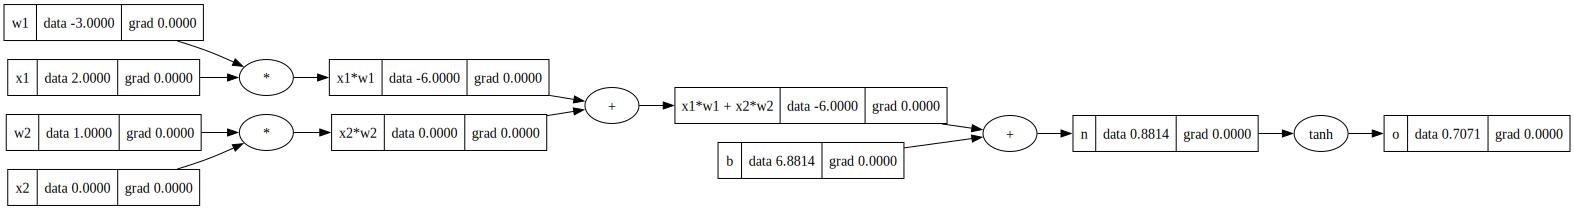

In [32]:
draw_dot(o)

In [33]:
#By using backpropagation we need to calculate the grad of the values starting from o til x1w1x2w2...

In [34]:
o.grad=1.0
o._backward()

In [35]:
n._backward()
b._backward()

In [36]:
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [37]:
#DONE


In [38]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [39]:
#Encountering a issue or a bug in backward() function and backpropagation thro function

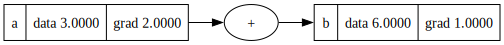

In [40]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

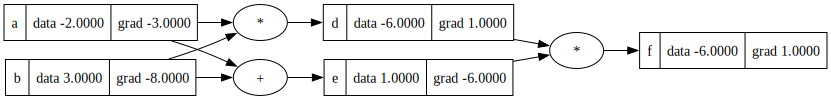

In [41]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [42]:
#Whenever a variable is used more than once in the set of equations then this problem of calculating the gradient arises

In [43]:
#We need to return the sum of the gardient and use it from backward function

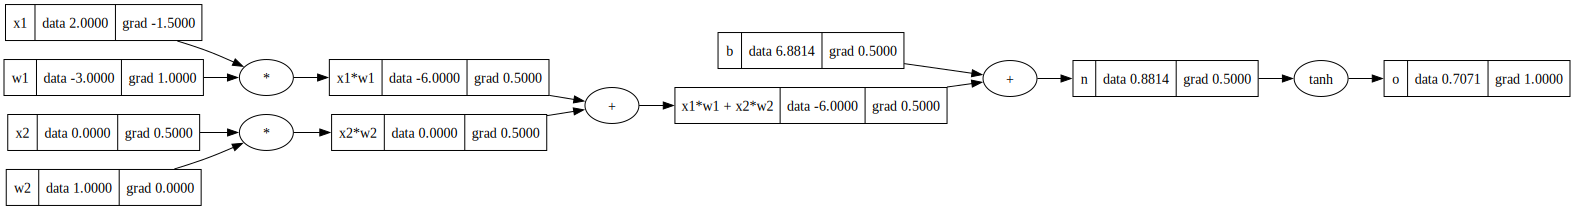

In [44]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

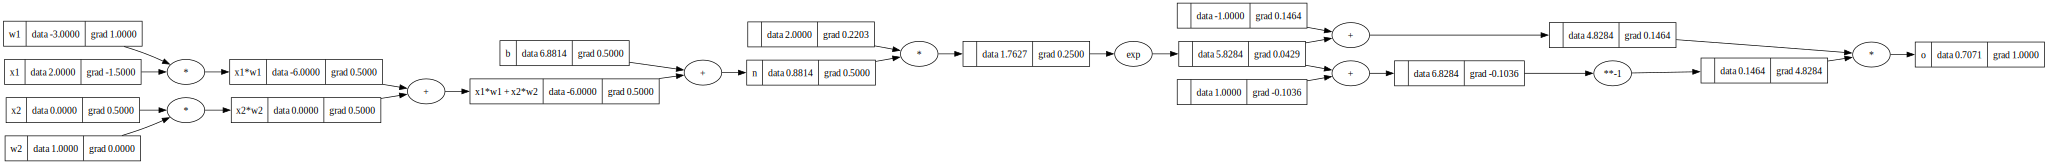

In [45]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [46]:
#So, this varifies the function of tanh(x) works fine as it gives the same output or chain when draw_dot is called.

In [47]:
import torch

In [48]:
#Doing the same thing using PyTorch tensors
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", lin

In [49]:
#So it gives out the same value so easily using PyTorch functions

In [50]:
# Building multi-layer perceptron

In [91]:
import random

In [107]:
class Neuron:
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b= Value(random.uniform(-1,1))

    def __call__(self,x):
        #wi * xi + b
        #Activation function
        act= sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out= act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
#Now after creating single layered neuron, we must focus on building a multi layered perceptron
#In MLP, Several disconnected neurons are present in a layer which all are connected to each of the inputs

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


#Now building multiple layers with multi dimentional neuron
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [93]:
#Here we are taking example of single layered x1*w1 + x2*w2 + b
x=[5.0,1.0]
n=Neuron(2)
n(x)

Value(data=-0.6846788677324865)

In [94]:
#Checking the working of the 2D- 3neuron layer in between input and output
x=[3.0, 5.0]
n= Layer(2,3)
n(x)

[Value(data=-0.9996206582786468),
 Value(data=0.9887087087070922),
 Value(data=-0.7221171545573327)]

In [95]:
#Now, finally we will be looking at the multi-layered perceptron 
#This example takes x1,x2,x3 for each neuron and four neurons hidden layer is connected to a single output
#2 layered MLP

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.08384924354049446)

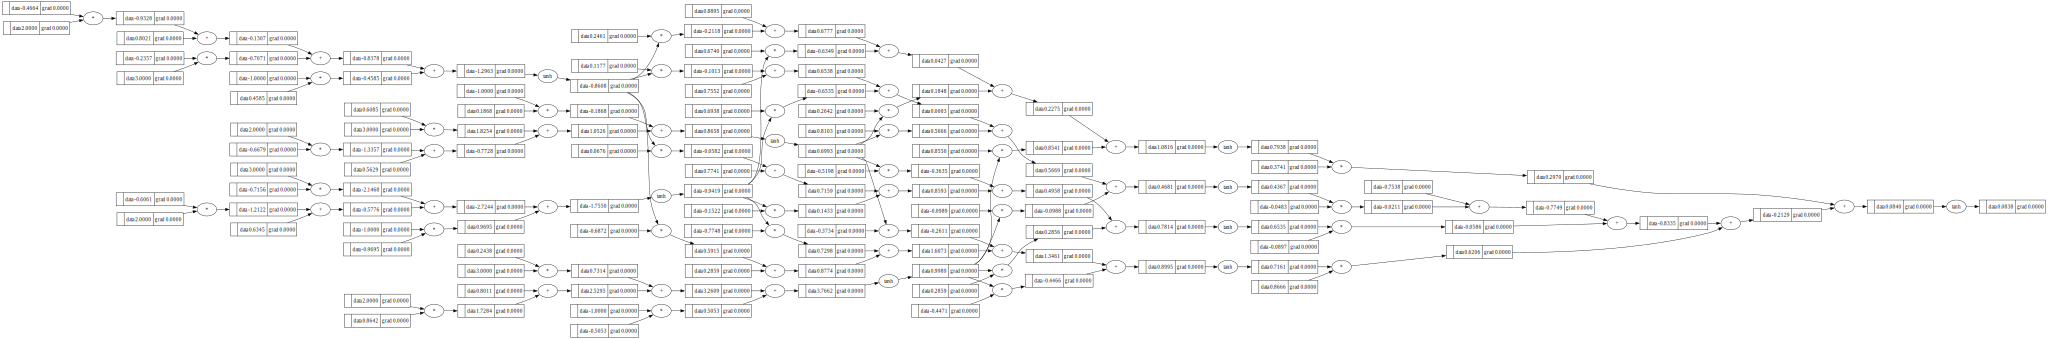

In [96]:
draw_dot(n(x))

In [97]:
#The above structure shows a multi layered perceptron 

In [98]:
#Now, our CNN Structure is ready with it's Multi layer perceptron model

In [101]:
#We will now focus on predicting a few values based on this
import numpy as np

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [105]:
ypred = [n(x).data for x in xs]

# Calculate mean squared error (MSE)
mse = np.mean([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

print("Predicted values:", ypred)
print("Mean Squared Error:", mse)

Predicted values: [0.08384924354049446, 0.07316679460515357, -0.5491004593544924, -0.6063131556717342]
Mean Squared Error: 1.1936428818607097


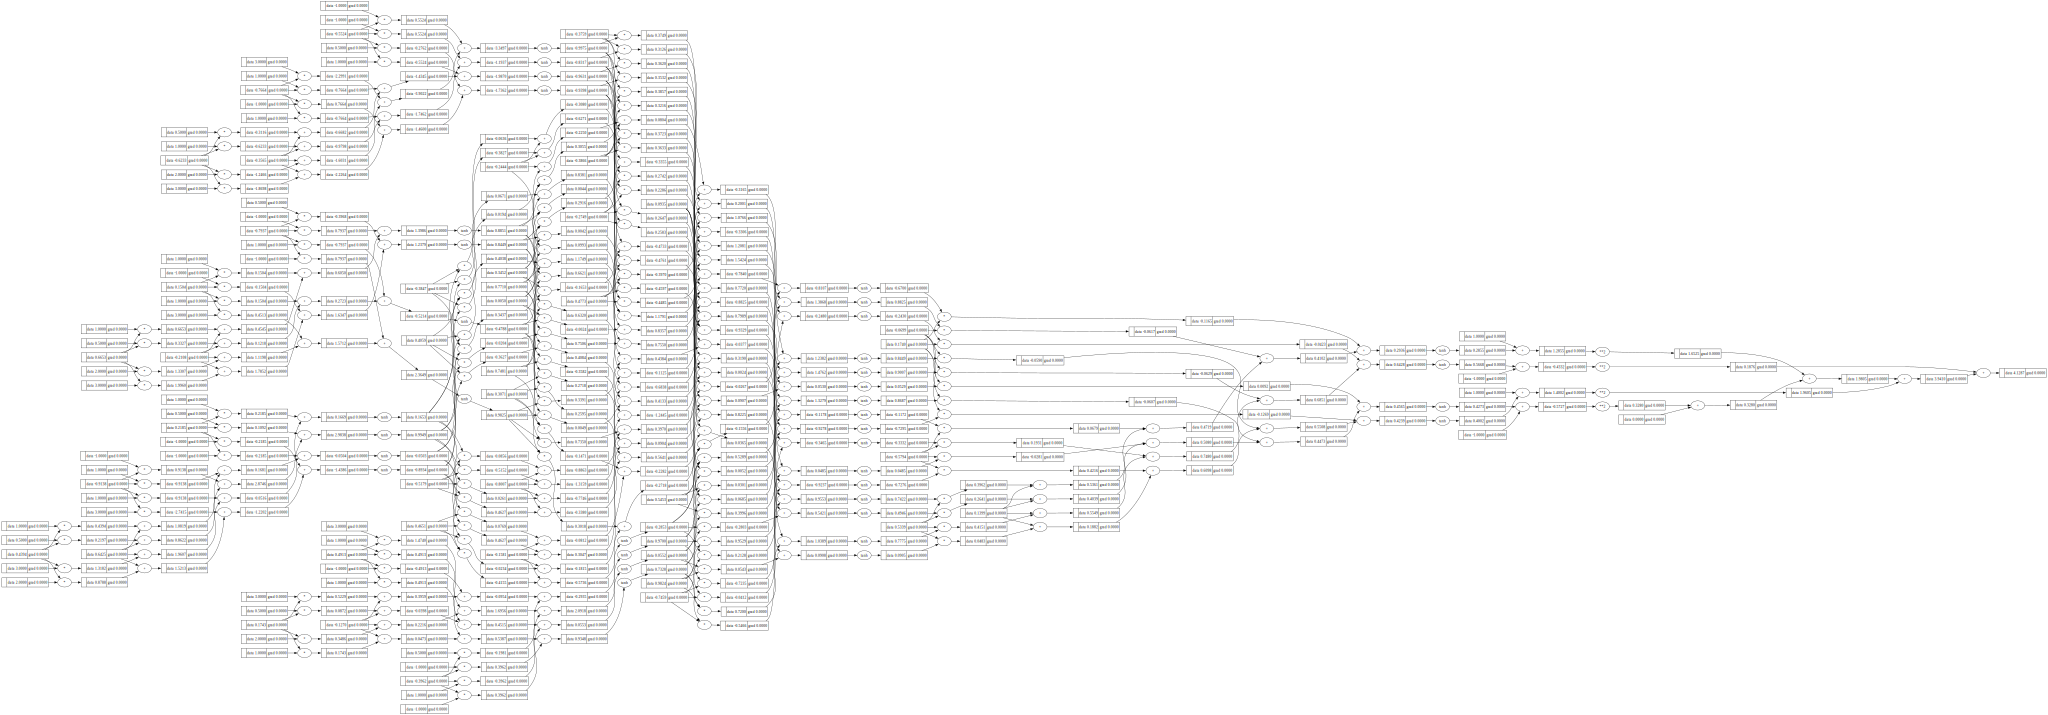

In [106]:
draw_dot(loss)

In [113]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.011017696669203964
1 0.010776923853942223
2 0.010545759851325814
3 0.010323653445143535
4 0.010110094440602032
5 0.009904609923560733
6 0.009706760923083051
7 0.00951613942710748
8 0.00933236570813346
9 0.009155085921786363
10 0.008983969946167791
11 0.008818709434173866
12 0.008659016054603291
13 0.008504619900982254
14 0.008355268049695809
15 0.008210723251299486
16 0.00807076274085402
17 0.007935177154827859
18 0.007803769543583625
19 0.007676354469743821


In [114]:
ypred

[Value(data=0.9524679336448678),
 Value(data=-0.9891841998683047),
 Value(data=-0.9409196926612651),
 Value(data=0.9574606900616973)]

In [115]:
ys

[1.0, -1.0, -1.0, 1.0]

In [ ]:
#So, finally after proper  finetuning with around 70 epochs of the CNN we got the results much near to that of the real output

In [ ]:
#End of CNN Notebook